# EIOPA RISK-FREE CURVE JULY-23 RECALCULATION
<a id="0"></a> <br>

The risk-free curve is one of the principal inputs into an economic scenario generator. This notebook recalculates the risk-free curve using the parameters that are claimed to be used. The European Insurance and Occupational Pensions Authority (EIOPA) publishes their own yield curve prediction. To do this they use the Smith & Wilson algorithm.

### Summary

The goal of this test is to replicate the EIOPA yield curve. This test will use the methodology that EIOPA claims it is using and the calibration vector that they publish. If the test is passed, the user can be more confident, that EIOPA risk free rate (RFR) curve was generated using the described methodology/calibration and that the process was implemented correctly. 


 # Table of Contents  
1. [Note on Smith & Wilson algorithm](#1)
2. [Data requirements](#2)
3. [Success criteria](#3)
4. [External dependencies](#4)
5. [Calibration parameters and calibration vector provided by EIOPA](#5)
6. [Smith & Wilson calculation functions](#6)
7. [Generation of the risk-free curve](#7)
8. [Test 1; Comparison test](#8)
9. [Test 1; Success criteria](#9)
10. [Test 1; Comparison test](#10)
11. [Conclusion](#11)

<a id="1"></a> <br>
## Note on Smith & Wilson algorithm

To replicate the calculations, this example uses a modified Smith&Wilson implementation (The original implementation is availible on [GitHub](https://github.com/qnity)):
-  [Python](https://github.com/qnity/insurance_python/tree/main/smith%26wilson)
-  [Matlab](https://github.com/qnity/insurance_matlab/tree/main/smith%26wilson)
-  [JavaScript](https://github.com/qnity/insurance_javascript/tree/main/smith-wilson)

#### Limitations of the implementation
Current implementation only looks at a single currency and with/without Volatility Adjustment (VA). The day count convention assumes that each year has the same number of days.

<a id="2"></a> <br>
## Data requirements

This script contains the EIOPA risk-free rate publication for July 2023. The publication can be found on the [EIOPA RFR website](https://www.eiopa.europa.eu/tools-and-data/risk-free-interest-rate-term-structures_en).

The observed maturities `M_Obs` and the calibrated vector `Qb` can be found in the Excel sheet *EIOPA_RFR_20230731_Qb_SW.xlsx*.

The target maturities (`T_Obs`), the additional parameters (`UFR` and `alpha`), and the given curve can be found in the Excel *EIOPA_RFR_20230731_Term_Structures.xlsx*, sheet *RFR_spot_no_VA* if the test looks at the curve without the Volatility Adjustment and the sheet *RFR_spot_with_VA* if the test looks at the curve with the Volatility Adjustment.

[Back to the top](#0)
<a id="3"></a> <br>
## Success criteria

The following success criteria is defined:
-  Maximum difference between the calculated curve and the one provided by EIOPA is less than 0.1 bps
-  Average difference between the calculated curve and the one provided by EIOPA is less than 0.05 bps

In [218]:
test_statistics_max_diff_in_bps = 0.1
test_statistics_average_diff_in_bps = 0.05

The success function is called at the end of the test to confirm if the success criteria have been met.

In [219]:
def SuccessTest(TestStatistics, threshold_max, threshold_mean):
    out1 = False
    out2 = False
    if max(TestStatistics)<threshold_max:
        print("Test passed")
        out1 = True
    else:
        print("Test failed")

    if np.mean(TestStatistics)<threshold_mean:
        print("Test passed")
        out2 = True
    else:
        print("Test failed")
    return [out1, out2]

[Back to the top](#0)
<a id="4"></a> <br>
         
## External dependencies

This implementation uses three well established Python packages widely used in the financial industry. Pandas (https://pandas.pydata.org/docs/), Numpy (https://numpy.org/doc/), and Matplotlib (https://matplotlib.org/stable/index.html)

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib notebook
pd.options.display.max_rows = 150

## Importing data

In [221]:
selected_param_file = 'Param_VA.csv'
selected_curves_file = 'Curves_VA.csv'

#selected_param_file = 'Param_no_VA.csv'
#selected_curves_file = 'Curves_no_VA.csv'

In [222]:
param_raw = pd.read_csv(selected_param_file, sep=',',index_col=0)

***
<span style=color:black>
    <b>Parameter input</b>
</span>
<br>
<span style=color:black>   
    Parameters sheet
</span>

In [223]:
param_raw.head()

,Euro_Maturities,Euro_Values,Austria_Maturities,Austria_Values,Belgium_Maturities,Belgium_Values,Bulgaria_Maturities,Bulgaria_Values,Croatia_Maturities,Croatia_Values,...,South Korea_Maturities,South Korea_Values,Taiwan_Maturities,Taiwan_Values,Thailand_Maturities,Thailand_Values,Turkey_Maturities,Turkey_Values,United States_Maturities,United States_Values
Country,,,,,,,,,,,,,,,,,,,,,
Coupon_freq,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,4.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1.000000,1.000000
LLP,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,10.000000,10.000000,15.00000,15.00000,9.000000,9.000000,30.000000,30.000000
Convergence,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,50.000000,50.000000,45.00000,45.00000,51.000000,51.000000,40.000000,40.000000
UFR,3.450000,3.450000,3.450000,3.450000,3.450000,3.450000,3.450000,3.450000,3.450000,3.450000,...,3.450000,3.450000,3.450000,3.450000,3.45000,3.45000,5.500000,5.500000,3.450000,3.450000
alpha,0.108242,0.108242,0.108242,0.108242,0.108242,0.108242,0.109036,0.109036,0.108242,0.108242,...,0.059729,0.059729,0.103315,0.103315,0.07051,0.07051,0.165581,0.165581,0.083087,0.083087


***

The country selected is:

In [224]:
country = "Turkey"

In [225]:
maturities_country_raw = param_raw.loc[:,country+"_Maturities"].iloc[6:]
param_country_raw = param_raw.loc[:,country + "_Values"].iloc[6:]
extra_param = param_raw.loc[:,country + "_Values"].iloc[:6]

***
<span style=color:black>
    <b>Extra parameters</b>
</span>
<br>
<span style=color:black>   
    Smith-Wilson calibration parameters
</span>

In [226]:
extra_param

Country
Coupon_freq     0.000000
LLP             9.000000
Convergence    51.000000
UFR             5.500000
alpha           0.165581
CRA            10.000000
Name: Turkey_Values, dtype: float64

***

In [227]:
relevant_positions = pd.notna(maturities_country_raw.values)

In [228]:
maturities_country = maturities_country_raw.iloc[relevant_positions]

***
<span style=color:black>
    <b>Maturity vector</b>
</span>
<br>
<span style=color:black>   
    Vector of maturities used in the calibration
</span>

In [229]:
maturities_country.head(15)

Country
1    1.0
2    2.0
3    3.0
4    4.0
5    5.0
6    6.0
7    8.0
8    9.0
Name: Turkey_Maturities, dtype: float64

***

In [230]:
Qb = param_country_raw.iloc[relevant_positions]

***
<span style=color:black>
    <b>Calibration vector</b>
</span>
<br>
<span style=color:black>   
    Vector <b>Qb</b> provided as input
</span>

In [231]:
Qb

Country
1    -2.594118
2    10.888107
3    -4.804714
4     0.023312
5    -2.015106
6    -0.304049
7    -0.981962
8     1.036681
Name: Turkey_Values, dtype: float64

***

In [232]:
curve_raw = pd.read_csv(selected_curves_file, sep=',',index_col=0)

In [233]:
curve_country = curve_raw.loc[:,country]

[Back to the top](#0)
<a id="5"></a> <br>
## Calibration parameters and calibration vector provided by EIOPA

In [234]:
# Maturity of observations:
M_Obs = np.transpose(np.array(maturities_country.values))

# Ultimate froward rate ufr represents the rate to which the rate curve will converge as time increases:
ufr = extra_param.iloc[3]/100

# Convergence speed parameter alpha controls the speed at which the curve converges towards the ufr from the last liquid point:
alpha = extra_param.iloc[4]

# For which maturities do we want the SW algorithm to calculate the rates. In this case, for every year up to 150:
M_Target = np.transpose(np.arange(1,151)) 

# Qb calibration vector published by EIOPA for the curve calibration:
Qb = np.transpose(np.array(Qb.values))

[Back to the top](#0)
<a id="6"></a> <br>
## Smith & Wilson calculation functions

In this step, the independent version of the Smith&Wilson algorithm is implemented. To do this, two functions are taken from the publicly available repository and modified to accept the product of `Q*b` instead of the calibration vector `b`.

In [235]:
def SWExtrapolate(M_Target, M_Obs, Qb, ufr, alpha):
# SWEXTRAPOLATE Interpolate or/and extrapolate rates for targeted maturities using a Smith-Wilson algorithm.
# out = SWExtrapolate(M_Target, M_Obs, Qb, ufr, alpha) calculates the rates for maturities specified in M_Target using the calibration vector b.
#
# Arguments: 
#    M_Target = k x 1 ndarray. Each element represents a bond maturity of interest. Ex. M_Target = [[1], [2], [3], [5]]
#    M_Obs =    n x 1 ndarray. Observed bond maturities used for calibrating the calibration vector b. Ex. M_Obs = [[1], [3]]
#    Qb =       n x 1 ndarray. Calibration vector calculated on observed bonds.
#    ufr =      1 x 1 floating number. Representing the ultimate forward rate.
#       Ex. ufr = 0.042
#    alpha =    1 x 1 floating number. Representing the convergence speed parameter alpha. Ex. alpha = 0.05
# 
#
# Returns:
#    k x 1 ndarray. Represents the targeted rates for a zero-coupon bond. Each rate belongs to a targeted zero-coupon bond with a maturity from T_Target. Ex. r = [0.0024; 0.0029; 0.0034; 0.0039]
#
# For more information see https://www.eiopa.europa.eu/sites/default/files/risk_free_interest_rate/12092019-technical_documentation.pdf

    def SWHeart(u, v, alpha):
    # SWHEART Calculate the heart of the Wilson function.
    # H = SWHeart(u, v, alpha) calculates the matrix H (Heart of the Wilson
    # function) for maturities specified by vectors u and v. The formula is
    # taken from the EIOPA technical specifications paragraph 132.
    #
    # Arguments:  
    #    u =     n_1 x 1 vector of maturities. Ex. u = [1; 3]
    #    v =     n_2 x 1 vector of maturities. Ex. v = [1; 2; 3; 5]
    #    alpha = 1 x 1 floating number representing the convergence speed parameter alpha. Ex. alpha = 0.05
    #
    # Returns:
    #    n_1 x n_2 matrix representing the Heart of the Wilson function for selected maturities and parameter alpha. H is calculated as in the paragraph 132 of the EIOPA documentation. 
    #
    # For more information see https://www.eiopa.europa.eu/sites/default/files/risk_free_interest_rate/12092019-technical_documentation.pdf

        u_Mat = np.tile(u, [v.size, 1]).transpose()
        v_Mat = np.tile(v, [u.size, 1])
        return 0.5 * (alpha * (u_Mat + v_Mat) + np.exp(-alpha * (u_Mat + v_Mat)) - alpha * np.absolute(u_Mat-v_Mat) - np.exp(-alpha * np.absolute(u_Mat-v_Mat))); # Heart of the Wilson function from paragraph 132

    H = SWHeart(M_Target, M_Obs, alpha) # Heart of the Wilson function from paragraph 132
    p = np.exp(-np.log(1+ufr)* M_Target) + np.diag(np.exp(-np.log(1+ufr) * M_Target)) @ H @ Qb # Discount pricing function for targeted maturities from paragraph 147
    return p ** (-1/ M_Target) -1 # Convert obtained prices to rates and return prices

[Back to the top](#0)
<a id="7"></a> <br>
## Generation of the risk-free curve

The observed maturities, target maturities, and the model parameters provided by EIOPA are used to generate the target curve.

In [236]:
r_Target = SWExtrapolate(M_Target,M_Obs, Qb, ufr, alpha)
r_Target = pd.DataFrame(r_Target,columns=['Recalculated rates'])

***
<span style=color:black>
    <b>Yield curve calculated</b>
</span>
<br>
<span style=color:black>   
    Yield curve calculated using the calibration vector <b>Qb</b>
</span>

In [237]:
r_Target.head(15)

,Recalculated rates
0,0.139454
1,0.149675
2,0.166894
3,0.182276
4,0.194183
5,0.201892
6,0.205980
7,0.207159
8,0.206124
9,0.204380


***

[Back to the top](#0)
<a id="8"></a> <br>
## Test 1; Comparison test
Comparison of the calculated yield curve with the yield curve provided by EIOPA. The test is passed if the success criteria is reached.


The provided yield curve can be found in file *EIOPA_RFR_20230731_Term_Structures.xlsx*, sheet *RFR_spot_no_VA* if the test looks at the curve without the Volatility Adjustment and the sheet *RFR_spot_with_VA* if the test looks at the curve with the Volatility Adjustment.

In [238]:
target_curve = np.transpose(np.array(curve_country.values)) 

This implementation looks at two kinds of test statistics. The average deviation and the maximum deviation. 

The average deviation is defined as:

<font size=4>
$$S_{AVERAGE} = \frac{1}{T} \sum_{t = 0}^T \left|r_{EIOPA}(t) - r_{EST}(t) \right|$$
</font> <br>

The maximum deviation is defined as:
<font size=4>
$$ S_{MAX} = \max_t \left| r_{EIOPA}(t) - r_{EST}(t) \right| $$
</font> <br>

Where `T` is the maximum maturity available. 

The average difference test is successful if:

<font size=4>
$$S_{AVERAGE} < 0.05 bps$$   
</font> <br>


The maximum difference test is successful if:

<font size=4>
$$ S_{MAX} <  0.1 bps $$
</font> <br>


In [239]:
target_curve = pd.DataFrame(target_curve,columns=['Given rates'])

***
<span style=color:black>
    <b>EIOPA curve provided</b>
</span>
<br>
<span style=color:black>   
    Yield curve provided by EIOPA
</span>

In [240]:
target_curve.head()

,Given rates
0,0.13945
1,0.14968
2,0.16689
3,0.18228
4,0.19418


In [241]:
x_data_label = range(2023,2023+r_Target.shape[0],1)

<IPython.core.display.Javascript object>


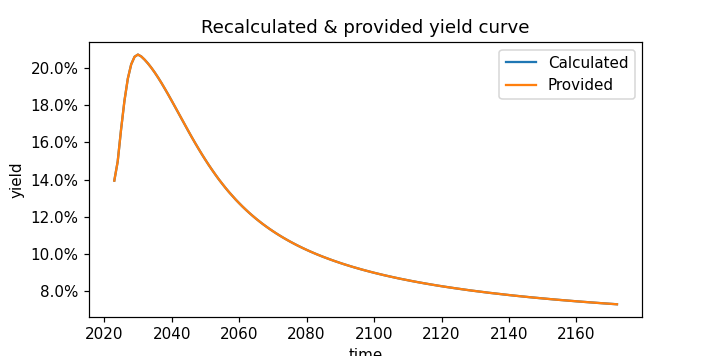

In [242]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(x_data_label, r_Target.values*100, color='tab:blue',label="Calculated")
ax1.plot(x_data_label, target_curve.values*100, color='tab:orange',label="Provided")

ax1.set_ylabel("yield")
ax1.set_title('Recalculated & provided yield curve')
ax1.set_xlabel("time")
ax1.legend()
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.set_figwidth(6)
fig.set_figheight(3)
plt.show()

***

In [243]:
test_statistics_bdp = pd.DataFrame(abs(r_Target.values-target_curve.values)*10000, columns=["Abs diff in bps"])

***
<span style=color:black>
    <b>EIOPA curve comparison</b>
</span>
<br>
<span style=color:black>   
    Absolute difference in bps
</span>

In [244]:
test_statistics_bdp.head()

,Abs diff in bps
0,0.040392
1,0.049192
2,0.044102
3,0.037470
4,0.027537


***

[Back to the top](#0)
<a id="9"></a> <br>
## Test 1; Success criteria

The successful application of the success criteria marks the completion of the test.

In [245]:
result1 = SuccessTest(test_statistics_bdp.values, test_statistics_max_diff_in_bps, test_statistics_average_diff_in_bps)

Test passed
Test passed


<IPython.core.display.Javascript object>


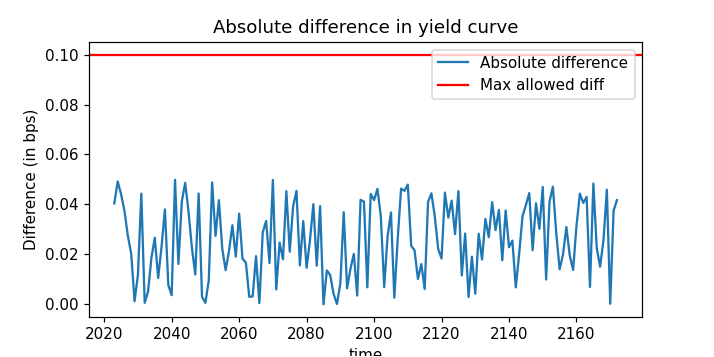

In [246]:
x_data_label = range(2023,2023+r_Target.shape[0],1)
fig, ax1 = plt.subplots(1,1)
ax1.plot(x_data_label, test_statistics_bdp, label= "Absolute difference")
ax1.axhline(y = test_statistics_max_diff_in_bps, color = 'r', linestyle = '-',label="Max allowed diff")

ax1.set_xlabel("time")
ax1.set_ylabel("Difference (in bps)")
ax1.set_title('Absolute difference in yield curve')
ax1.legend()
fig.set_figwidth(6)
fig.set_figheight(3)

plt.show()

[Back to the top](#0)
<a id="10"></a> <br>
## Conclusion

This test checks the success criteria on the EIOPA curve generated for July 2023. If the tests are passed, it is likely that the curve was generated using the Smith & Wilson algorithm with the calibration vector that was provided in the file *EIOPA_RFR_20230731_Qb_SW.xlsx* and the parameters displayed in the file *EIOPA_RFR_20230731_Term_Structures.xlsx*.

In [247]:
pd.DataFrame(data = [result1], columns = ["Mean test","Max test"],  \
             index= ["Provided vs calculated"])

,Mean test,Max test
Provided vs calculated,True,True


***
<span style=color:black>
    <b>Final yield curve</b>
</span>
<br>
<span style=color:black>   
    Full yield curve provided by EIOPA in %
</span>

In [248]:
(curve_country*100).head(150)

Country
1      13.945
2      14.968
3      16.689
4      18.228
5      19.418
6      20.189
7      20.598
8      20.716
9      20.612
10     20.438
11     20.233
12     20.002
13     19.748
14     19.474
15     19.183
16     18.879
17     18.563
18     18.239
19     17.909
20     17.577
21     17.244
22     16.913
23     16.586
24     16.265
25     15.950
26     15.644
27     15.346
28     15.058
29     14.780
30     14.512
31     14.255
32     14.008
33     13.772
34     13.545
35     13.328
36     13.121
37     12.922
38     12.732
39     12.551
40     12.377
41     12.211
42     12.052
43     11.900
44     11.754
45     11.614
46     11.480
47     11.352
48     11.229
49     11.110
50     10.996
51     10.887
52     10.782
53     10.680
54     10.583
55     10.489
56     10.398
57     10.310
58     10.226
59     10.144
60     10.065
61      9.989
62      9.915
63      9.844
64      9.775
65      9.708
66      9.643
67      9.580
68      9.519
69      9.460
70      9.402
71      9.34